In [3]:
import sys
print(sys.executable)
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#
import ssl

print(ssl.get_default_verify_paths())



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


/usr/local/bin/python3.10
DefaultVerifyPaths(cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', capath=None, openssl_cafile_env='SSL_CERT_FILE', openssl_cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', openssl_capath_env='SSL_CERT_DIR', openssl_capath='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/certs')
2.16.1


In [4]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1934745636013667248
xla_global_id: -1
]
[]


In [5]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [43]:
import tensorflow as tf

class MaxDropout(tf.keras.layers.Layer):
    def __init__(self, max_rate, **kwargs):
        super(MaxDropout, self).__init__(**kwargs)
        self.max_rate = max_rate  # The maximum possible dropout rate

    def call(self, inputs, training=None):
        if not training:
            return inputs
        
        # Step 3: Dynamically select a dropout rate between 0 and self.max_rate
        rate = tf.random.uniform((), 0, self.max_rate)

        # Step 4: Normalize the tensor using L2 normalization
        norm_tensor = tf.nn.l2_normalize(inputs, axis=None)

        # Step 5: Find the maximum value in the normalized tensor
        max_val = tf.reduce_max(norm_tensor)

        # Step 6: Calculate the threshold to keep
        threshold = (1 - rate) * max_val

        # Step 7: Create a mask for elements greater than the threshold
        kept_idx = tf.cast(norm_tensor < threshold, inputs.dtype)
        # print the number of zeros in kept_idx
        # num_zeros = tf.cast(tf.size(kept_idx), tf.float32) - tf.reduce_sum(kept_idx)
        # tf.print("Number of zeros in the mask:", num_zeros)
        # Step 8: Return the tensor with dropout applied
        return inputs * kept_idx


In [44]:
#Build model

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxDropout(0.2))


model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxDropout(0.2))


# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(100, activation='softmax'))

# Print the model summary
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_28 (MaxDropout)     │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_dropout_29 (MaxDropout)     │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,388 (1.74 MB)

 Trainable params: 456,388 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every 
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.0385 - loss: 4.2892 - val_accuracy: 0.1496 - val_loss: 3.5849
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.1678 - loss: 3.4388 - val_accuracy: 0.2355 - val_loss: 3.0898
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.2607 - loss: 2.9189 - val_accuracy: 0.2999 - val_loss: 2.7846
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.3344 - loss: 2.5511 - val_accuracy: 0.3350 - val_loss: 2.5912
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.3869 - loss: 2.3044 - val_accuracy: 0.3611 - val_loss: 2.4615
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.4320 - loss: 2.0836 - val_accuracy: 0.3748 - val_loss: 2.4553
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.4781 - loss: 1.8894 - val_accuracy: 0.3875 - val_loss: 2.4549
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.5093 -

In [46]:
print(val_loss)

[3.5849032402038574, 3.089751958847046, 2.7845869064331055, 2.5912437438964844, 2.4615378379821777, 2.4552602767944336, 2.4549381732940674, 2.457986354827881, 2.57071590423584, 2.5884814262390137]


In [47]:
#Evaluate the model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 3s - 10ms/step - accuracy: 0.3872 - loss: 2.5885

Test accuracy: 0.3871999979019165


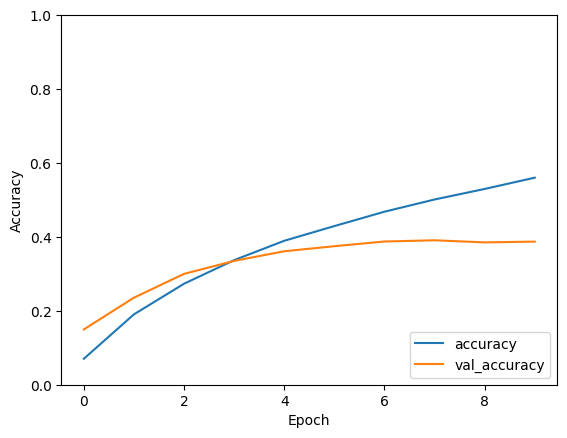

In [48]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


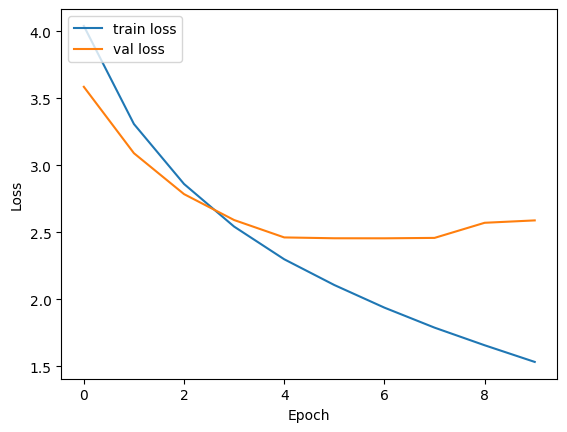

In [49]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')  

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()


Sample of class to superclass mapping: {19: 11, 29: 15, 0: 4, 11: 14, 1: 1}
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


<Figure size 1000x1000 with 0 Axes>

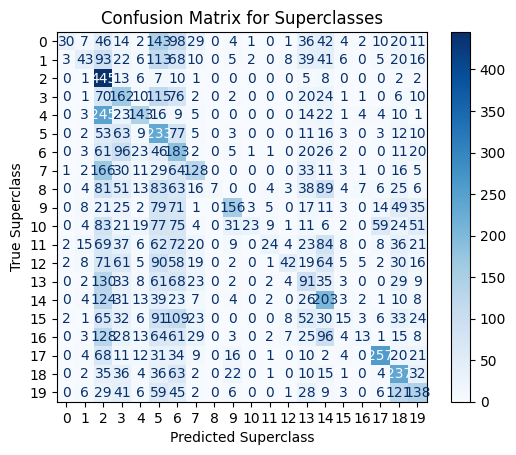

In [50]:
## CONFUSION MATRIX
# Load both fine and coarse labels
(x_train_fine, y_train_fine), (x_test_fine, y_test_fine) = cifar100.load_data(label_mode='fine')
(x_train_coarse, y_train_coarse), (x_test_coarse, y_test_coarse) = cifar100.load_data(label_mode='coarse')

# Establish a mapping from fine labels to coarse labels
class_to_superclass = {}
for fine, coarse in zip(y_train_fine.flatten(), y_train_coarse.flatten()):
    if fine not in class_to_superclass:
        class_to_superclass[fine] = coarse

# Optional: Check the mapping (for understanding/debugging)
print("Sample of class to superclass mapping:", {k: class_to_superclass[k] for k in list(class_to_superclass)[:5]})

# Predict the classes using the trained model
y_pred = model.predict(x_test_fine)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_super = np.vectorize(class_to_superclass.get)(y_pred_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix for superclasses
cm_super = confusion_matrix(y_test_coarse, y_pred_super)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_super)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Superclasses')
plt.xlabel('Predicted Superclass')
plt.ylabel('True Superclass')
plt.show()



## Save the trained Model

In [52]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar100_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save('cifar100_cnn_weights.h5')


## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar100_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar100_cnn_weights.h5')